<a href="https://colab.research.google.com/github/lqmeyers/Bee_Visit_Count/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bee Visit Counter Complete Pipeline 

This document contains all the steps you need to get drinkging and visit events from a video of the artificial flowerpatch

### Import Relevant Software into Google Colab Runtime 

1. First, we will do is clone Bee_Visit_Count from the github repository

In [1]:
!git clone --recurse-submodules https://github.com/lqmeyers/Bee_Visit_Count.git
!ls /content/Bee_Visit_Count
%cd /content/Bee_Visit_Count

Cloning into 'Bee_Visit_Count'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 92.42 MiB | 25.45 MiB/s, done.
Resolving deltas: 100% (96/96), done.
displayJSON.py	       flowerFinder.py	plotFramePreview.py   visitDetect.py
drinkingDetect.py      Images		README.md
drinkingValidation.py  LICENSE		Tracks
eventDetect.py	       Models		updateConfigFrame.py
/content/Bee_Visit_Count


  * Use the remove line below if you are making changes to Bee_Visit_Count modules and need to reclone the new versions. Often reloading the page and restarting runtime will also be necessary to avoid errors 

In [ ]:
!rm -r /content/Bee_Visit_Count #use if restarting code after updating bee_visit_count

2. Next we will install SLEAP, the program used to run inference and generate tracks using the nueral network

In [ ]:
!pip uninstall -y opencv-python opencv-contrib-python
!pip install sleap

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


### Import Necessary Files for Analysis 

There are several ways to import your video file for analysis, you fill find some of them listed or explained below.

* You can import them directly from your local directory, but this procress is very slow 

In [ ]:
from google.colab import files
vidFile = files.upload() #creates prompt to select file from explorer #REALLY SLOW

* You could also upload them to work session files, using the icon on the left in the files section of the side menu. This can also be slow however and will need to be repeated each time runtime is restarted. 

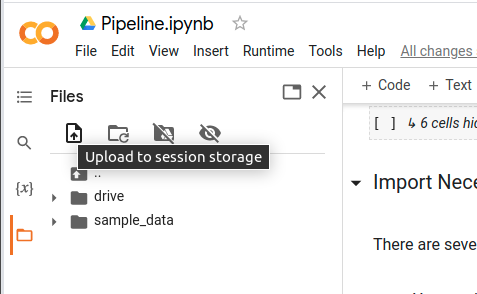

* **The fastest method** is to upload a zip file containing the video for analysis to your google drive. You can mount your drive, search for it in the file window on the left, and copy path into command below. This will directly insert video into working environment. Only unzipping will need to be repeated if runtime is restarted. 

In [ ]:
!unzip "/content/drive/MyDrive/IQBIO_REU/fixed3x6_22_22_test.zip" -d "/content" #this is the fastest

Archive:  /content/drive/MyDrive/IQBIO_REU/fixed3x6_22_22_test.zip
  inflating: /content/fixed3x6_22_22_test.mp4  


### Running Inference using SLEAP

Next we're going to run inference on this video, using pretrained models using SLEAP.  

1. the code below will run inference on the entirety of the video. It will scan through each frame, finding predicted instances of bees, and generate tracks by matching them to detections in the previous frame. It will output a .predictions.slp file in the same location as the video. Make sure to update the paths within the command to your specific data. 

In [ ]:
!sleap-track /content/fixed3x6_22_22_test.mp4 \
  -m /content/Bee_Visit_Count/Models/220629_124207.centroid.n=170 \
  -m /content/Bee_Visit_Count/Models/220629_124207.centroid.n=170/220629_130840.centered_instance.n=170 \
  --tracking.tracker simple \

  
  


2. Next, we will convert the predictions file into an h5 dataset for analysis. It will again be saved to the same location as the input file. 

In [ ]:
!sleap-convert --format analysis -o "/content/fixed3x6_22_22_test.mp4.predictions.analysis.h5.h" "/content/fixed3x6_22_22_test.mp4.predictions.slp"

3. It may be useful to **save these two files** to your google or local directory, in order to save time in future sessions if you will be analyzing the same video, as **they will both be deleted upon runtime discontinuation.** 

### Configuring Flower Patch 

Before we can analyze our predicted tracks, we need to gather some postitional data about the flower patch that the bees are visiting. 

1. Import some modules and helper code from Bee_Visit_Count. If modules not detected, check working dir or if git clone worked correctly 

In [ ]:
!pwd
import flowerFinder as ff
import eventDetect as ed


/content/Bee_Visit_Count


2. Update the configuration image by taking the first frame from the video we analyzed. Will print 'True' if successful.

In [ ]:
import cv2 
cap = cv2.VideoCapture('/content/fixed3x6_22_22_test.mp4')
ret, frame = cap.read()
cv2.imwrite('/content/Bee_Visit_Count/Images/targetFrame.tiff',frame)

True

3. Assign some convenient variable names to paths. Again make sure that the path strings match the files generated from your own dataset. This is a good step to load in external h5 files if prediction was done previously either inside or outside pipeline. 

In [ ]:
imgFile = '/content/Bee_Visit_Count/Images/targetFrame.tiff'
#trackFile = '/content/Bee_Visit_Count/Tracks/validation_22_22_6.analysis.h5.h'
#trackFile = '/content/fixed3x6_22_22_test.mp4.predictions.analysis.h5.000_fixed3x6_22_22_test.analysis.h5'
trackFile = '/content/drive/MyDrive/IQBIO_REU/fixed3x6_22_22_test.mp4.predictions.analysis.h5.000_fixed3x6_22_22_test.analysis.h5'

4. Run flowerFinder module to generate flower patch configuration information. Second argument is the expected number of flowers in the patch. Don't forget to update if need be. 

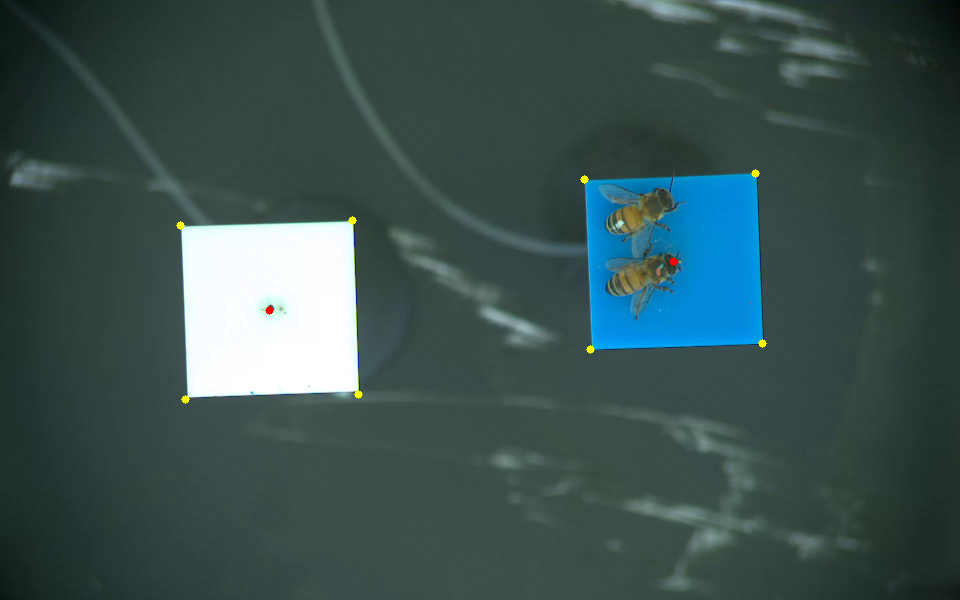

In [ ]:
ff.main(imgFile,2,show_validation=True,run_on_colab=True) 

5. If the image above looks correct you are ready to extract event information from your predicted tracks. This step may throw errors if flowers are incorrectly detected. 

### Getting Event Data 

Now we will extract visit imformation using the proximity of predicted tracks to the flower patch locations. 

* The code below creates an event object, which allows several display configurations, as well as writes raw data to a json document. Again, **make sure to save this file** if you want to reanalyze in the future. 

In [ ]:
e = ed.events(trackFile)
e.displayEvents()

initializing
track array shape =  (381, 22500, 4, 2)
finding visits
LAST FRAME DETECT
LAST FRAME DETECT
finding drinking bees
writing output
╒═════════════════╤════════════╤════════════╕
│ Event Type      │   Flower 0 │   Flower 1 │
╞═════════════════╪════════════╪════════════╡
│ Drinking Nectar │        201 │        158 │
├─────────────────┼────────────┼────────────┤
│ Flower Visits   │        262 │        195 │
╘═════════════════╧════════════╧════════════╛


The event class can also display information about just visits or drinking events. All display tables can be configured per flower or per individual, specified using mode argument. Below is the diplay of visits per track_Id. SLEAP's track generation software frequently creates new tracks when individuals are occuluded from frame, not to mention leaving frame, so this number is likly signficantly higher than the total number of bees to visit the patch.  

In [ ]:
e.displayVisits('perIndividual')

╒════════════╤══════════════════════╤══════════════════════╕
│   Track ID │   Visits to Flower 0 │   Visits to Flower 1 │
╞════════════╪══════════════════════╪══════════════════════╡
│          0 │                    0 │                    0 │
├────────────┼──────────────────────┼──────────────────────┤
│          1 │                    0 │                    1 │
├────────────┼──────────────────────┼──────────────────────┤
│          2 │                    0 │                    0 │
├────────────┼──────────────────────┼──────────────────────┤
│          3 │                    1 │                    1 │
├────────────┼──────────────────────┼──────────────────────┤
│          4 │                    0 │                    0 │
├────────────┼──────────────────────┼──────────────────────┤
│          5 │                    2 │                    1 │
├────────────┼──────────────────────┼──────────────────────┤
│          6 │                    0 │                    1 │
├────────────┼──────────